# Random forest 

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
https://www.youtube.com/watch?v=J4Wdy0Wc_xQ

In [22]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint
from sklearn.ensemble import RandomForestRegressor

from sklearn import tree

## 4.1 Create useful functions 

In [2]:
#def MAPE 
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
#define evaluation function 
def evaluation(y_true, y_pred):
    print("RMSE:", np.sqrt(mean_squared_error(y_pred, y_true)))
    print("MAPE:", mean_absolute_percentage_error(y_true, y_pred))

In [4]:
#define a function to split the dataset between training and test 
def train_test_split(length, X, y, ratio):
    X_train = X.iloc[:int(length*ratio)]
    y_train = y.iloc[:int(length*ratio)]
    X_test = X.iloc[int(length*ratio):]
    y_test = y.iloc[int(length*ratio):]
    return X_train, y_train, X_test, y_test

In [5]:
def model_prediction(func, X_train, y_train, X_test):
    y_pred = func.fit(X_train, y_train).predict(X_test)
    return y_pred

In [6]:
def plot_prediction(y_pred, y_test, xlabel, ylabel, title, png):
    plt.figure(0, figsize=(12,5))
    plt.plot(y_pred, '--', c='r', label='pred.', lw=2)
    plt.plot(y_test.values, c='black', label='actual', lw=2)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title, fontsize=17)
    plt.grid(which = 'both')
    plt.legend(fontsize=13)
    plt.savefig(png)
    plt.show()

In [7]:
def report(results, n_top=3):
    '''https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
    '''
    # Utility function to report best scores
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## 4.2 Load and prepare data 

In [8]:
df = pd.read_csv("C:/Users/julie/supervised_project/PS2021.csv", index_col='Unnamed: 0')
df.head()

,day_ahead_p,load,impFR,impNL,impCZ,impPL,impAT,temp_DE,temp_DE2,roll_std24,...,day,month,year,weekday,season,temp,HDD,CDD,sim_wthr_fcst,sim_wthr_fcst2
2015-01-04 23:00:00+00:00,22.34,49275.75,617.0,0.0,828.0,0.0,0.0,1.483241,2.200005,12.763541,...,4,1,2015,7,1,-16.516759,0,1,-0.340471,0.115920
2015-01-05 00:00:00+00:00,17.93,47116.50,676.0,0.0,807.0,0.0,0.0,1.451013,2.105438,12.763541,...,5,1,2015,1,1,-16.548987,0,1,0.260916,0.068077
2015-01-05 01:00:00+00:00,15.17,45836.75,788.0,0.0,808.0,0.0,0.0,1.409041,1.985395,12.763541,...,5,1,2015,1,1,-16.590959,0,1,0.729922,0.532786
2015-01-05 02:00:00+00:00,16.38,45674.00,986.0,0.0,807.0,0.0,0.0,1.317127,1.734824,12.763541,...,5,1,2015,1,1,-16.682873,0,1,2.782545,7.742554
2015-01-05 03:00:00+00:00,17.38,46536.75,996.0,0.0,828.0,0.0,0.0,1.178413,1.388658,12.763541,...,5,1,2015,1,1,-16.821587,0,1,1.856353,3.446046


In [9]:
#define X and y 
X = df[[
    'sim_wthr_fcst',
    'sim_wthr_fcst2',
    'weekday', 
    'hour', 
    'season', 
    'year',
    'impFR_lag24',
    'impNL_lag24',
    'impCZ_lag24',
    'impAT_lag24',
    'impPL_lag24',
    'load_lag24'
       ]]

X_price = df[[
    'sim_wthr_fcst',
    'sim_wthr_fcst2',
    'weekday',
    'hour',
    'season',
    'year',
    'impFR_lag24',
    'impNL_lag24',
    'impCZ_lag24',
    'impPL_lag24',
    'impAT_lag24',
    'day_ahead_p_lag24',
    'roll_std24_lag24']]

y = df['load']
    

#Create training and test datasets 
X_train, y_train, X_test, y_test = train_test_split(len(df), X, y, 0.75)

## 4.3 Hyperparameter tuning

In this section I provide a set of hyperparameters on which the algorithm will iterate to find optimal combination. This section comes from here : https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74.


In [10]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [11]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 90.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [45]:
#the report function prints the 3 best models hyperparameters 
report(rf_random.cv_results_)

Model with rank: 1
Mean validation score: 0.937 (std: 0.005)
Parameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}

Model with rank: 2
Mean validation score: 0.937 (std: 0.005)
Parameters: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': True}

Model with rank: 3
Mean validation score: 0.937 (std: 0.005)
Parameters: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}



## 4.4 Estimation 

In [36]:
#Estimate random Forest using the optimal combination of parameters 
regr = RandomForestRegressor(n_estimators=600, 
                             min_samples_split=2, 
                             min_samples_leaf=4, 
                             max_features="auto", 
                             max_depth=40, 
                             bootstrap=True).fit(X_train, y_train)

preds = regr.predict(X_test)

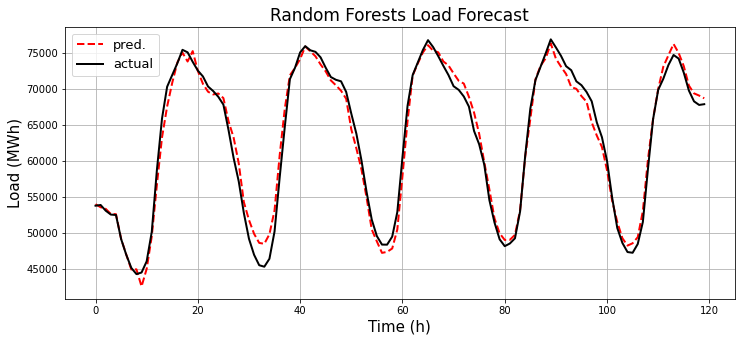

RMSE: 3119.9940566235186
MAPE: 2.8419008002338955


In [50]:
#Plot predictions 
plot_prediction(preds[:120], 
                y_test[:120], 
                "Time (h)", 
                "Load (MWh)", 
                "Random Forests Load Forecast", 
                "reg_tree_pred.png.png")

evaluation(y_test, preds)

## 4.5 Plot Trees 

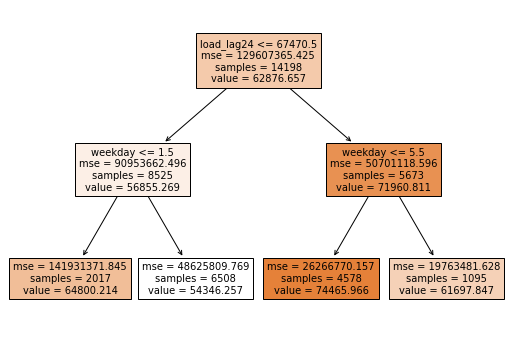

In [44]:
regr = RandomForestRegressor(n_estimators=100, 
                             min_samples_split=2, 
                             min_samples_leaf=4, 
                             max_features="auto", 
                             max_depth=2, 
                             bootstrap=True).fit(X_train, y_train)


plt.figure(figsize=(9,6))
tree.plot_tree(regr.estimators_[0], feature_names=X.columns, filled=True)
plt.savefig('reg_tree_plot_2.png')

## 4.6 Features Importance

Text(0, 0.5, 'Feature Importance')

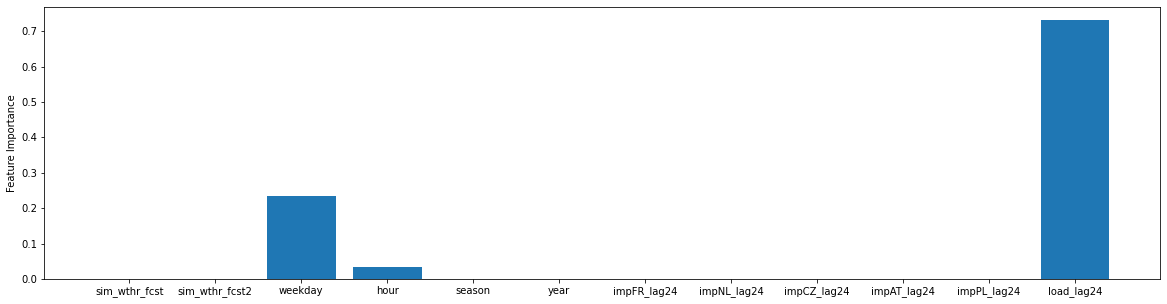

In [34]:
features_importances = regr.feature_importances_

plt.figure(figsize=(20,5))
plt.bar(X_train.columns.to_list(),features_importances)
plt.ylabel("Feature Importance")